In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats

# Load parameter distributions -- F04

In [105]:
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
capT = 10000
γ = 1/(80*365)
Input_H = [1500,0,0,0]
parameters = [Input_H, capT]

In [107]:
# θ = np.load('ABC/theta_SEIR.npy')
# tols = np.load('ABC/tols_SEIR.npy')
# θ = np.load('ABC/ABC_season/theta_Season_F10.npy')
θ = np.load('ABC/ABC_season/theta_Season_F04_3.npy')
# θ = np.load('ABC/theta_F_combined1.npy')
# tols = np.load('ABC/tols_F_combined1.npy')
a_β, loc_β, scale_β = stats.gamma.fit(θ[4][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[4][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[4][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[4][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[4][:,4]])

# Use SEIR model -- split up rate from human to human and external

In [108]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
#         print(Rtotal)
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]
#                 , R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
#             print(cuminf)
            if event == 0:
                num_external +=1
            if event == 1:
                num_internal +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
#         print(pop[ind])
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death

In [109]:
external = []
internal = []
total = []
death = []
for k in range(5000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR_season(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [110]:
k


4798

In [111]:
np.mean([death[a]/total[a] for a in range(len(death))])

0.5059614266727259

In [112]:
print('percent external forcing', 100*np.mean([external[a]/total[a] for a in range(len(external))]),'%')
print('percent human to human', 100*np.mean([internal[a]/total[a] for a in range(len(internal))]),'%')

percent external forcing 56.22285940494199 %
percent human to human 43.777140595058015 %


{'boxes': [<matplotlib.lines.Line2D at 0x7f9ab8877208>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9ab8877c18>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ab88878d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ab88874a8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9ab8877358>,
  <matplotlib.lines.Line2D at 0x7f9ab88777f0>]}

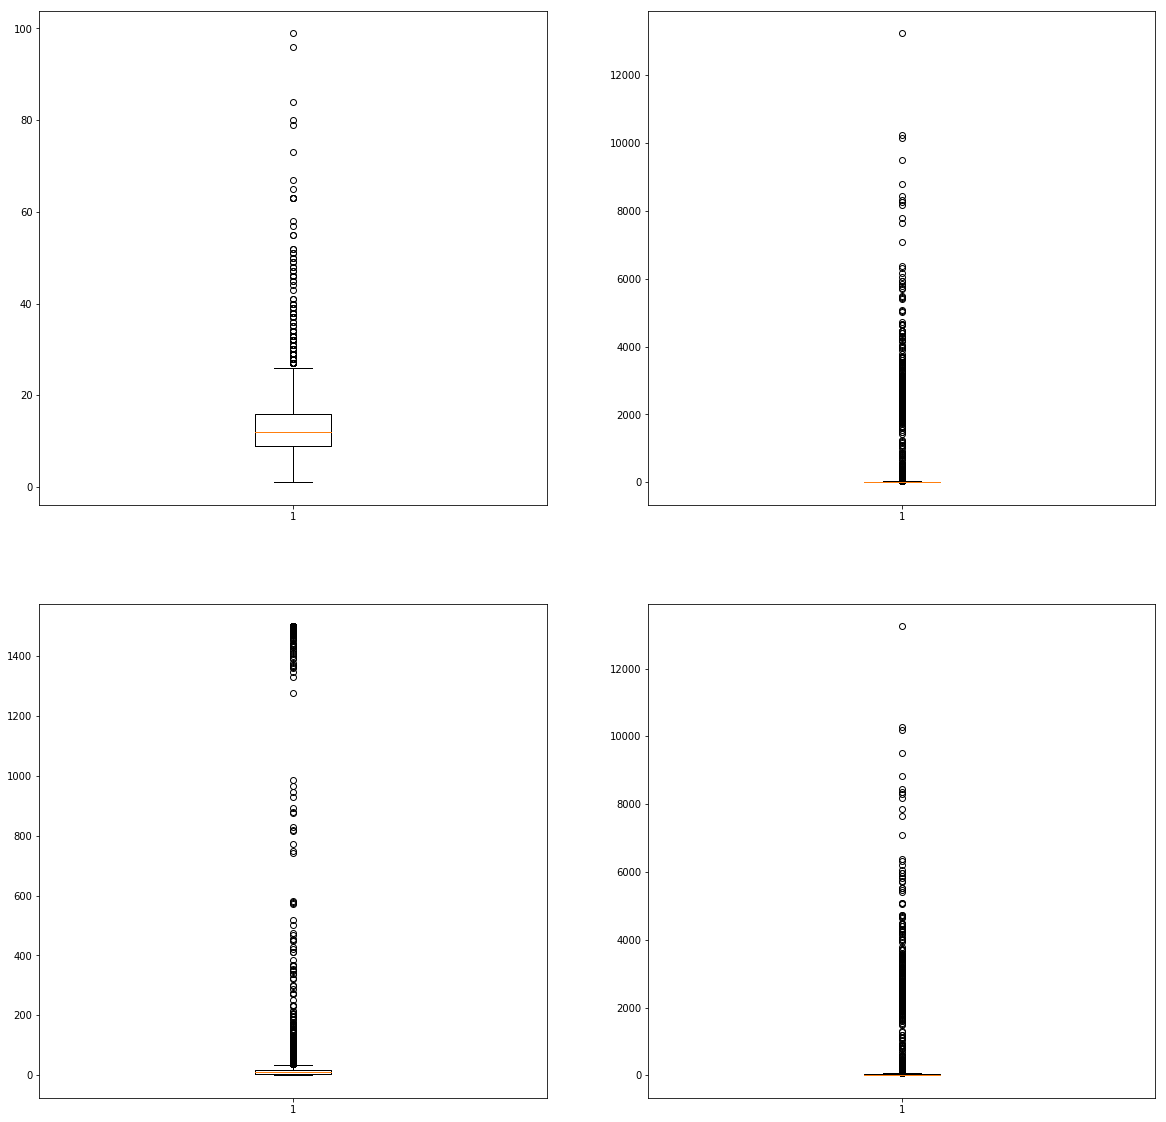

In [113]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
# plt.boxplot([external[a]/total[a] for a in range(len(external))])
plt.boxplot(external)

plt.subplot(2,2,2)
# plt.boxplot([internal[a]/total[a] for a in range(len(internal))])
plt.boxplot(internal)

plt.subplot(2,2,3)
# plt.boxplot([death[a]/total[a] for a in range(len(death))])
plt.boxplot(death)
plt.subplot(2,2,4)
plt.boxplot(total)

# Reproductive Number -- 72 years (2015) in Bangladesh but 67 (2004)

In [83]:
# μ = 1/(67*365)
# β = stats.gamma.rvs( a_β, loc_β, scale_β)
# μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
# μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
# ϵ = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
# σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
# N = 1500

In [103]:
R_0_H = (β*σ)/((σ+μ)*(μ1+μ2+μ)) 
R_0_H

0.2058950322091674

# Fit Expoential to growth rate -- rate per day per population level

In [102]:
from scipy.optimize import curve_fit

In [86]:
# Gh=gillespieSEIR(parameters[0], β, μ1,μ2,
#                           σ,ϵ,  parameters[1])
# SEIHRt_s = Gh[0]
# SEIHRs_s = Gh[1][:,0]
# SEIHRe_s = Gh[1][:,1]
# SEIHRi_s = Gh[1][:,2]
# # SEIHRh_s = Gh_season[1][:,3]
# SEIHRr_s = Gh[1][:,3]

In [87]:
# len(SEIHRt_s)

In [88]:
# manhes = []
# manhts = []
# manhhs = []
# manhis = []
# manhss = []
# manhrs = []
# cum = []
# for ind, x in enumerate(SEIHRt_s):
#     if ind<len(SEIHRt_s)-1:
#         manhes.append((SEIHRe_s[ind], SEIHRe_s[ind]))
#         cum.append((Gh[3][ind], Gh[3][ind]))
# #         manhhs.append((SEIHRh_s[ind], SEIHRh_s[ind]))
#         manhis.append((SEIHRi_s[ind], SEIHRi_s[ind]))
#         manhss.append((SEIHRs_s[ind], SEIHRs_s[ind]))
#         manhrs.append((SEIHRr_s[ind], SEIHRr_s[ind]))
#         manhts.append((SEIHRt_s[ind], SEIHRt_s[ind+1]))
# manhes = np.array(manhes).flatten()
# manhts = np.array(manhts).flatten()
# manhss = np.array(manhss).flatten()
# manhrs = np.array(manhrs).flatten()
# cum = np.array(cum).flatten()
# # manhhs = np.array(manhhs).flatten()
# manhis = np.array(manhis).flatten()

In [89]:
# plt.plot(manhts, cum)

In [90]:
# plt.figure(figsize = (20,8))
# # plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
# plt.plot(manhts, manhes/N,c='orange', label = 'exposed')
# # plt.plot(manhts, manhhs/Nn,c='magenta', label = 'hospital')

# # plt.plot(manhts,manhrs/Nn, c='yellowgreen',label = 'susceptible')
# plt.plot(manhts,manhis/N,c= 'r', label = 'infected')
# plt.legend(fontsize = 20)
# plt.xlim([0,300])

In [91]:
# def func(x,  r):
#     return np.exp(r * x) 
# popt, pcov = curve_fit(func, manhts, cum)

In [92]:
# plt.figure(figsize = (20,8))
# plt.plot(manhts, func(manhts, *popt))
# plt.plot(manhts, manhes, color = 'orange')
# plt.plot(manhts, np.exp(0.17*manhts), color = 'black', label ='exponential fit')
# plt.plot(manhts, cum, color = 'green', label = 'cumulative')
# plt.legend(fontsize = 20)
# plt.ylim([0, 20])
# # plt.xlim([0,10])

In [93]:
# R_ϵ0 =  np.exp(0.17*((1/σ) +np.maximum((1/μ1),(1/μ2)) ))
# R_ϵ0

In [94]:
# R_0  = R_ϵ0 + R_0_H
# R_0

# Number of Exposed

In [95]:
def SEIRexposed(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    exposed = 0
    Rtotal = 1
    death = 0
    while pop[ind][2]<1:
#         print(Rtotal)
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]
#                 , R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
#             print(cuminf)
            if event == 0:
                num_external +=1
                exposed +=1 
            if event == 1:
                num_internal +=1
                exposed +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
#         print(pop[ind])
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death, exposed

In [96]:
external = []
internal = []
total = []
death = []
exposed = []
for k in range(5000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=SEIRexposed(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])
    exposed.append(M[7])

2

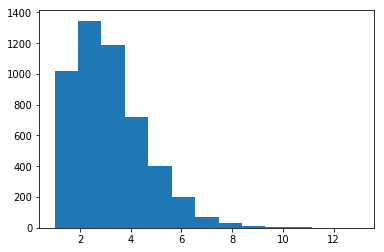

In [101]:
plt.hist(exposed, bins = np.max(exposed))
stats.mode(exposed)[0][0]

In [99]:

# Data_F04=pd.read_csv("Case_data/2004_F_cases.csv",sep = ',', header = 0)
# ############################# Spacing ##############################################
# date_format = "%d/%m/%y"


# def Spacing(dataset):
#     record = []
#     record.append(datetime.strptime(dataset['Date'][0], date_format).day)
#     for i in range(1, len(dataset)):
#         record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
#     start_day = (datetime.strptime(Data_F04['Date'].values[0], date_format)-datetime.strptime('01/11/03', date_format)).days
#     record = [int(a - record[0]) for a in record]
#     record = [int(a +start_day) for a in record]

#     return record

# Rec_F04=Spacing(Data_F04)
# Cum_F04 = Data_F04['CumsumInf'].values
# leng = len(np.arange(0, Rec_F04[0], 2))
# Rec_F04 = np.insert(Rec_F04, 0, np.arange(0, Rec_F04[0], 2))
# Cum_F04 = np.insert(Cum_F04, 0, np.zeros(leng))
# summary = np.array([Rec_F04, Cum_F04])
# plt.plot(M[0], M[3])
# plt.plot(summary[0][:20], summary[1][:20])